<a href="https://colab.research.google.com/github/andrea-acampora/Data_Intensive_Project/blob/main/Progetto_Data_Intensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predizione della salute del feto con dati forniti da cardiotocografie**

***Acampora Andrea***

Ingegneria e Scienze Informatiche \\
Università di Bologna, sede di Cesena \\
Corso di Programmazione di Applicazioni Data Intensive

## **Descrizione del problema e analisi esplorativa**

Il dataset scelto contiene i risultati di cardiotocografie eseguite sui feti durante la gravidanza.
La cardiotocografia è un esame molto diffuso per la valutazione del benessere del feto in ambito prenatale.
L'obbiettivo del progetto è quello di riuscire a prevedere una variabile discreta che rappresenta la salute del feto in base ai dati forniti dalle cardiotocografie.

Il dataset è disponibile al seguente link: https://www.kaggle.com/andrewmvd/fetal-health-classification

### Caricamento dei dati

Vengono importate tutte le librerie neccesarie per il progetto

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os.path

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

In [4]:
import os.path
if not os.path.exists("fetal_health.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/andrea-acampora/Data_Intensive_Project/main/fetal_health.csv", "fetal_health.csv")

dataset = pd.read_csv('fetal_health.csv')
dataset.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


### Significato delle features


Le **features** del dataset sono le seguenti:


*   **baseline_value**: frequenza cardiaca del feto 
*   **accelerations**: numero di accelerazioni del battito cardiaco per secondo
*   **fetal_movement**: numero di movimenti del feto per secondo
*   **uterine_contractions**: numero di contrazioni dell'utero per secondo
*   **light_decelerations**: numero di  decelerazioni brevi del battito cardiaco
*   **severe_decelerations**: numero di decelerazioni consistenti del battito cardiaco
*   **prolongued_decelerations**: numero di decelerazioni prolungate del battito cardiaco
*   **abnormal_short_term_variability**: indica la variabilità del battito cardiaco
*   **mean_value_of_short_term_variability** valore medio di oscilazioni brevi
*   **percentage_of_time_with_abnormal_long_term_variability**: percentuale di tempo con oscillazioni anormali
*   **mean_value_of_long_term_variability**: valore medio di oscillazioni prolungate. \\
Le seguenti variabili rappresentano invece i dati dell'istogramma ovvero l'output della cardiotocografia
*   **histogram_width**
*   **histogram_min**
*   **histogram_max**
*   **histogram_number_of_peaks**
*   **histogram_number_of_zeroes**
*   **histogram_mode**
*   **histogram_variance**
*   **histogram_tendency**
*   **fetal_health**

### Analisi delle features

In [5]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


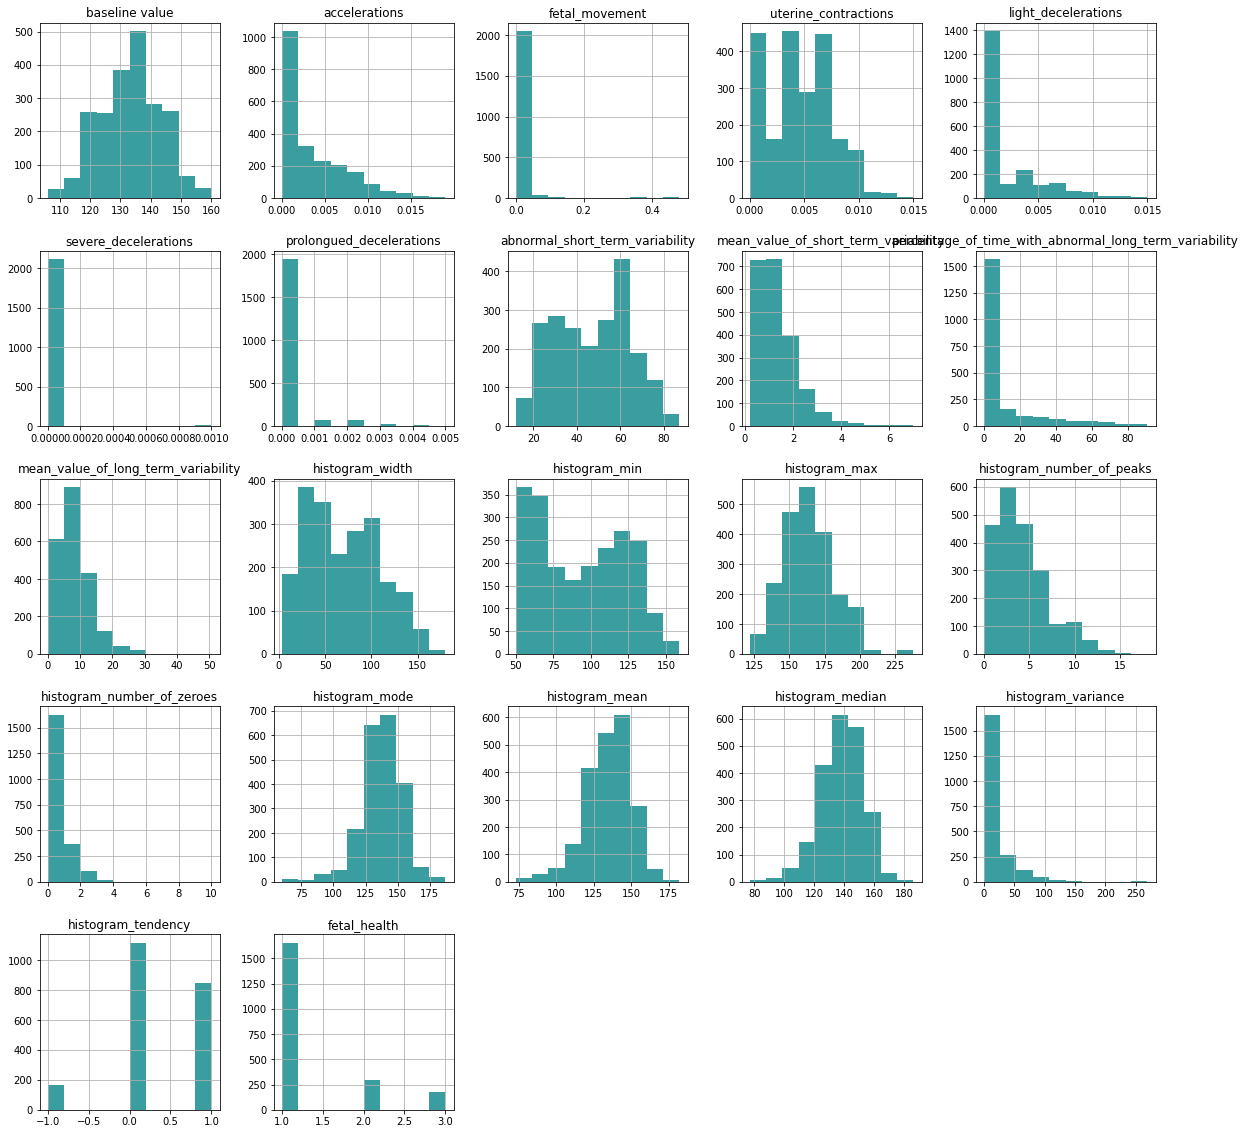

In [6]:
dataset.hist(figsize = (20,20), color = "#3A9DA0");

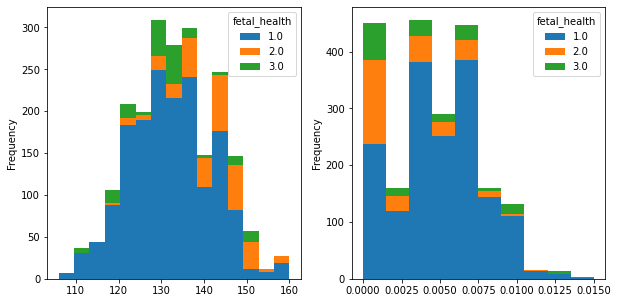

In [7]:
plt.figure(figsize=(10,5))

dataset.pivot(columns="fetal_health")["baseline value"].plot.hist(bins=15,stacked=True,ax=plt.subplot(1,2 , 1));
dataset.pivot(columns="fetal_health")["uterine_contractions"].plot.hist(stacked=True,ax=plt.subplot(1, 2, 2));


In questi grafici si può già notare la correlazione tra i battiti cardiaci e le contrazioni uterine con la salute del feto.

### Analisi della variabile da predire

La variabile da predire è ***fetal_health*** che rappresenta la salute del feto e contiene valori:
* 1 - Normale
* 2 - Sospetto 
* 3 - Patologico \\
Nella cella seguente possiamo notare come nel 77% dei casi il feto risulta completamente in salute, nel 13% presenta delle anomalie sospette mentre solo nel 0.08% presenta delle patologie.

In [8]:
dataset["fetal_health"].value_counts(normalize=True)

1.0    0.778457
2.0    0.138758
3.0    0.082785
Name: fetal_health, dtype: float64

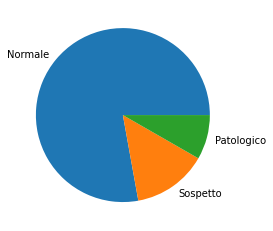

In [9]:
plt.pie(dataset["fetal_health"].value_counts(normalize=True), labels=["Normale", "Sospetto","Patologico"]);

Le 3 classi individuate risultano abbastanza sbilanciate, in seguito applicheremo delle tecniche di bilanciamento per migliorare l'accuratezza dei risultati.

### Analisi della correlazione delle features

Nel grafico seguente andremo ad analizzare quali sono le variabili che hanno una correlazione maggiore con la variabile da predire *fetal_health*. \\
Dalla matrice di correlazione possiamo notare che le variabili più scure come ad esempio **prolongued_decelerations**,**abnormal_short_term_variability** e **percentage_of_time_with_abnormal_long_term_variability** risultano essere quelle con una correllazione maggiore.

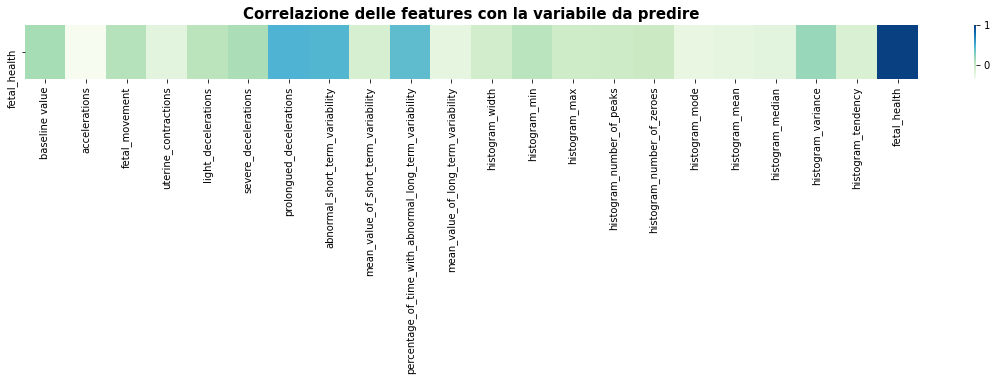

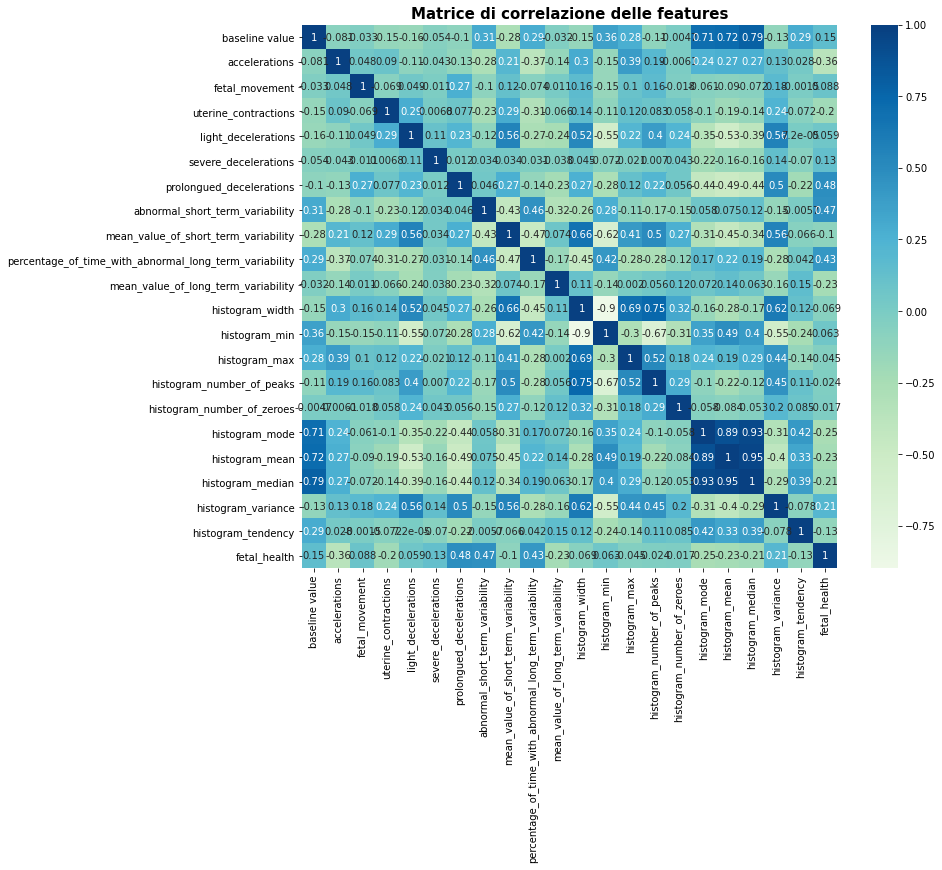

In [10]:
correlation_matrix = dataset.select_dtypes(exclude="object").corr()
f,ax=plt.subplots(figsize=(20,1))
sns.heatmap(correlation_matrix.sort_values(by=["fetal_health"], ascending=False).head(1), cmap="GnBu")
plt.title("Correlazione delle features con la variabile da predire", weight="bold", fontsize=15)
plt.show()

plt.figure(figsize=(12,10))  
plt.title("Matrice di correlazione delle features",weight="bold", fontsize=15)
cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(correlation_matrix,annot=True, cmap="GnBu", center=0);

## **Preprocessing dei dati**

### Distribuzione dei valori delle variabili

Il grafico seguente mostra il range di valori che assumono le nostre features.
Si può notare che le variabili hanno intervalli diversi e sarà quindi necessario applicare delle tecniche di standardizzazione dei dati per migliorare l'accuratezza dei modelli.

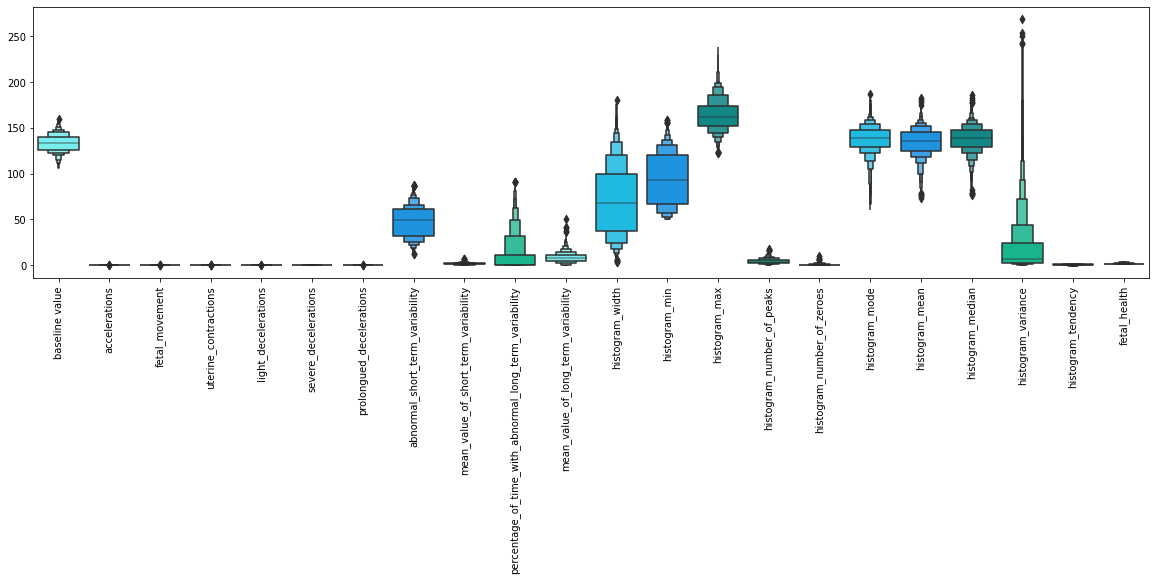

In [13]:
def plot_features_range(dataset):
  colors =["#66ffff","#00ccff","#0099ff","#009999", "#00cc99"]
  plt.figure(figsize=(20,5))
  sns.boxenplot(data = dataset,palette = colors)
  plt.xticks(rotation=90)
  plt.show()
plot_features_range(dataset)

### Standardizzazione dei dati

Utilizziamo il filtro StandardScaler per standardizzare i nostri dati e ripetiamo il grafico precedente per vedere i risultati ottenuti.

Dal grafico possiamo notare che , una volta applicata la standardizzazione , le variabili assumono tutte valori in un intervallo vicino.

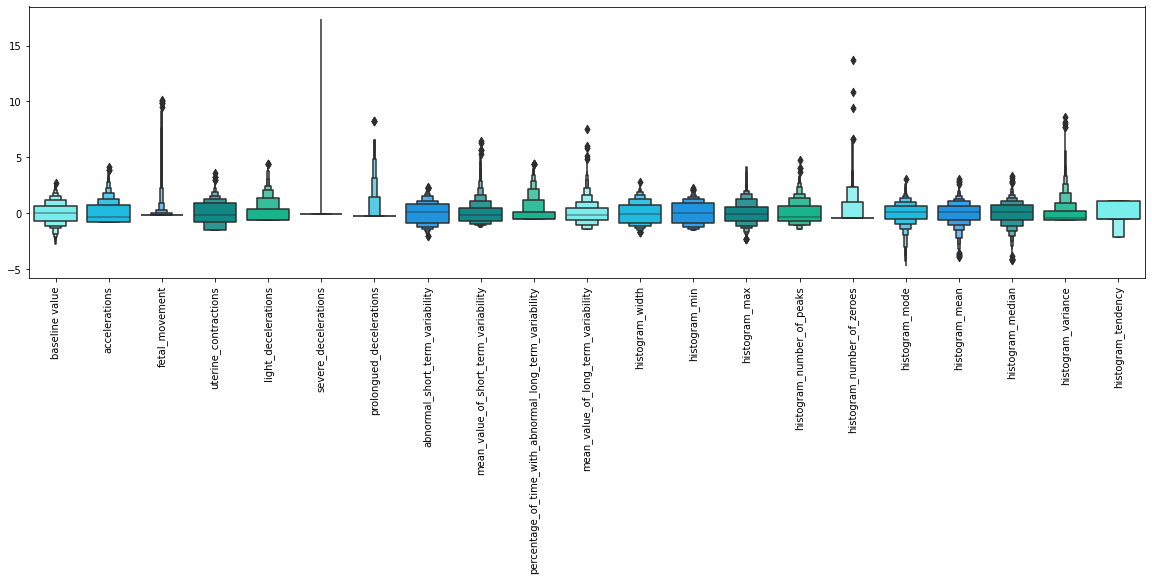

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X=dataset.drop(["fetal_health"],axis=1)
y=dataset["fetal_health"]

features = list(X.columns)
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=features)   

plot_features_range(X_std)

### Splitting dei dati in Training e Validation Sets

Prima di addestrare i nostri modelli andiamo a dividere il dataset in Training e Validation Set.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print("Training Set: "+ str(X_train.shape) + "\n"+ "Validation Set: " + str(X_test.shape))

Training Set: (1488, 21)
Validation Set: (638, 21)


## **Modelli di classificazione**

Creiamo la funzione *grid_search_with_cross_validation()* che andremo ad utilizzare nei vari modelli in modo da evitare ripetizioni di codice.

In [82]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import math
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

models = {}
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

def grid_search_with_cross_validation(model, parameters, kf, X_train,y_train,X_val,y_val, scoring=None):
    grid_search = GridSearchCV(model, parameters, scoring=scoring, cv=kf, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    score = grid_search.score(X_test, y_test)
    print("                Score: {}".format(score))
    print("                Best params: {}\n".format(grid_search.best_params_))
    return grid_search.best_estimator_, score


### Perceptron

Inizialmente andremo ad addestrare il modello di classificazione *Perceptron* senza specificare nessun parametro per vedere come si comporta sul dataset.

In [75]:
perceptron_model = Perceptron(random_state=42)
perceptron_model.fit(X_train,y_train)
perceptron_model.score(X_test,y_test)

0.8557993730407524

Andiamo ora ad aggiungere al nostro classificatore una serie di iperparametri che verranno testati tramite GridSearch

In [80]:
perceptron = Pipeline([
    ("per",Perceptron(random_state=42))
])

parameters_1 = {
    "per__penalty": ["l2", "l1", "elasticnet"],
    "per__alpha": np.logspace(-3, 3, 7)
}

parameters_2 = {
    "per__penalty": ["l2", "l1", "elasticnet"],
    "per__alpha": np.logspace(-3, 3, 7),
    "per__fit_intercept": [False, True],
    'per__class_weight': [None, "balanced"]
}

per_model, score = grid_search_with_cross_validation(perceptron, parameters, k_fold, X_train,y_train,X_test,y_test)
per_model_1, score = grid_search_with_cross_validation(perceptron, parameters_1, k_fold, X_train,y_train,X_test,y_test)
per_model_2, score = grid_search_with_cross_validation(perceptron, parameters_2, k_fold, X_train,y_train,X_test,y_test)

models["Perceptron"] = {"Model": per_model, "Score": score}


                Score: 0.8557993730407524
                Best params: {}

                Score: 0.8463949843260188
                Best params: {'per__alpha': 0.001, 'per__penalty': 'l1'}

                Score: 0.8072100313479624
                Best params: {'per__class_weight': 'balanced'}



Possiamo notare che aggiungendo la regolarizzazione l1 ed l2 ed anche applicando tecniche di bilanciamento delle classi lo score del modello non aumenta.

### Polynomial Perceptron

In [92]:
poly_perceptron = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('perceptron', Perceptron(n_jobs=-1, n_iter_no_change=5))
])

parameters={}
per_model, score = grid_search_with_cross_validation(poly_perceptron, parameters, k_fold, X_train,y_train,X_test,y_test)

                Score: 0.8996865203761756
                Best params: {}



In [85]:
poly_perceptron = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('per', Perceptron(n_jobs=-1, n_iter_no_change=5))
])

parameters = {
    "per__penalty": ["l2", "l1", "elasticnet"],
    "per__alpha": np.logspace(-3, 3, 7),
    "per__fit_intercept": [False, True],
    'per__class_weight': [None, "balanced"]
}

per_model, score = grid_search_with_cross_validation(poly_perceptron, parameters, k_fold, X_train,y_train,X_test,y_test)

                Score: 0.8996865203761756
                Best params: {}

